In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
# LAYERS
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1=0, bias_regularizer_l1=0, 
                 weight_regularizer_l2=0, bias_regularizer_l2=0):
        
        # Initializing random weights and biases
        self.weights = 0.01 * np.random.normal(loc=0, scale=1.0, size=(n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))
        # Initializing regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l2 = bias_regularizer_l2
     
    # Calculating neuron output (input for activation function)
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    # Calculating partial derivatives        
    def backward(self, dvalues):
        self.dinputs = np.dot(dvalues, self.weights.T)
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Updating gradient depending on regularization_loss
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
            
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.dbiases)
            dL1[self.bias < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
    def get_parameters(self):
        return self.weights, self.biases
    
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Conv2D:
    def __init__(self, filter_size, step_size=1, padding=0,
                 weight_regularizer_l1=0, bias_regularizer_l1=0, 
                 weight_regularizer_l2=0, bias_regularizer_l2=0):

        self.filter_n, self. filter_c, self.filter_h, self.filter_w = filter_size
        self.step_size = step_size
        self.padding = padding

        self.weights = 0.1 * np.random.normal(loc=0, scale=1, size=(self.filter_n, self.filter_c, self.filter_h, self.filter_w))
        self.biases = 0.1 * np.random.normal(loc=0,scale=1, size=(self.filter_n, 1))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        n_filters, d_filter, h_filter, w_filter = self.weights.shape
        n_x, d_x, h_x, w_x = inputs.shape
        h_out = (h_x - h_filter + 2 * self.padding) / self.step_size + 1
        w_out = (w_x - w_filter + 2 * self.padding) / self.step_size + 1

        if not h_out.is_integer() or not w_out.is_integer():
            raise Exception('Invalid output dimension!')

        h_out, w_out = int(h_out), int(w_out)

        X_col = im2col_indices(inputs, h_filter, w_filter, padding=self.padding, stride=self.step_size)
        W_col = self.weights.reshape(n_filters, -1)

        out = np.dot(W_col, X_col) + self.biases
        out = out.reshape(n_filters, h_out, w_out, n_x)
        self.output = out.transpose(3, 0, 1, 2)

        self.cache = (inputs, self.weights, self.biases, self.step_size, self.padding, X_col)

    def backward(self, dvalues):
        inputs, W, b, stride, padding, X_col = self.cache
        n_filter, d_filter, h_filter, w_filter = self.weights.shape

        self.dbiases = np.sum(dvalues, axis=(0, 2, 3))
        self.dbiases = self.dbiases.reshape(n_filter, -1)

        dvalues_reshaped = dvalues.transpose(1, 2, 3, 0).reshape(n_filter, -1)
        self.dweights = np.dot(dvalues_reshaped, X_col.T)
        self.dweights = self.dweights.reshape(self.weights.shape)

        weights_reshape = self.weights.reshape(n_filter, -1)
        dinputs_col = np.dot(weights_reshape.T, dvalues_reshaped)
        self.dinputs = col2im_indices(dinputs_col, inputs.shape, h_filter, w_filter, padding=self.padding, stride=self.step_size)
    
    def get_parameters(self):
        return self.weights, self.biases
    
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases


class Layer_MaxPool2D:
    def __init__(self, filter_size, step_size):
        self.filter_h, self.filter_w = filter_size
        self.step_size = step_size
    
    def forward(self, inputs, training):
        self.inputs_shape = inputs.shape
        N, C, W, H = self.inputs_shape
        out_height = int((H - self.filter_h) / self.step_size + 1)
        out_width = int((W - self.filter_w) / self.step_size + 1)

        k, i, j = get_im2row_indices(self.inputs_shape, self.filter_h, self.filter_w, padding=0, stride=self.step_size)
        inputs_row = inputs[:, k, i, j]
        indices_argmax = np.argmax(inputs_row, axis=2)

        row = np.arange(len(k))
        self.i = i[row, indices_argmax]
        self.j = j[row, indices_argmax]
        self.k = np.tile(np.repeat(np.arange(C), out_height * out_width), (N, 1))
        self.n = np.arange(N)[:, None]

        self.output = inputs[self.n, self.k, self.i, self.j].reshape(N, C, out_height, out_width)

    def backward(self, dvalues):
        N, C, W, H = dvalues.shape
        empty_array = np.zeros(self.inputs_shape)
        empty_array[self.n, self.k, self.i, self.j] = dvalues.reshape(N, -1)
        self.dinputs = empty_array

class Layer_Flatten:
    def __init__(self):
        pass

    def forward(self, inputs, training):
        n_inputs, d_inputs, h_inputs, w_inputs = inputs.shape
        self.inputs = inputs
        self.output = inputs.reshape(n_inputs, -1)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.reshape(self.inputs.shape)


def get_im2col_indices(x_shape, field_height, field_width, padding=0, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_width) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))


def im2col_indices(x, field_height, field_width, padding=0, stride=1):
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=1, field_width=1, padding=0, stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def convolve(array, filter, *, step_size=1):
    used = False
    if len(array.shape) is 2:
        array = array[None, None, :, :]
        filter = filter[None, None, :, :]
        used = True

    batch_size, array_channels, array_height, array_width = array.shape
    filter_number, filter_channels, filter_height, filter_width = filter.shape

    width_end = array_width - filter_width
    height_end = array_height - filter_height
    steps_width = width_end // step_size + 1
    steps_height = height_end // step_size + 1

    first_channel_start = (np.arange(filter_height)[:, None] * array_width + np.arange(filter_width))
    start = np.arange(array_channels)[:, None] * array_width * array_height + first_channel_start.ravel()
    shift = np.arange(0, height_end + 1, step_size)[:, None] * array_width + np.arange(0, width_end + 1, step_size)
    batch_shift = np.arange(batch_size)[:, None] * array_width * array_height * array_channels + shift.ravel()
    coordinates = start.ravel()[:, None] + batch_shift.ravel()
    subset_in_column = np.take(array, coordinates) 
    
    output = np.dot(filter.reshape(filter_number, -1), subset_in_column)
    output = np.reshape(output, (filter_number, steps_width, steps_height,  batch_size), order='F')
    output = output.transpose(3, 0, 2, 1)
    if used:
        output = output.reshape(steps_height, steps_width)

    return output

def get_im2row_indices(x_shape, field_height, field_width, padding=0, stride=1):
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_width) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    i = i.T.reshape(out_height * out_width, C, field_height * field_width).transpose(1, 0, 2).reshape(-1, field_height * field_width)
    j = j.T.reshape(out_height * out_width, C, field_height * field_width).transpose(1, 0, 2).reshape(-1, field_height * field_width)

    k = np.repeat(np.arange(C), out_height * out_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))


class Layer_Dropout:
    def __init__(self, rate=0):
        self.rate = 1 - rate
        
    def forward(self, inputs, training):
        self.inputs = inputs
        
        if not training:
            self.output = self.inputs
            return
        
        self.binary_mask = np.random.binomial(n=1, p=self.rate, size=self.inputs.shape) / (self.rate)
        self.output = self.inputs * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

class Layer_Input:
    def __init__(self):
        pass
    def forward(self, inputs, training):
        self.output = inputs

        
        
# ACTIVATIONS
class Activation_ReLU:
    def __init__(self):
        pass
    
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues
        self.dinputs[self.inputs <= 0] = 0
        
    def prediction(self, output):
        return output

class Activation_Linear:
    def __init__(self):
        pass
    
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

    def predictions(self, output):
        return output
    
class Activation_Softmax:
    def __init__(self):
        pass
    def forward(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.amax(inputs, axis=1, keepdims=True))
        exp_values_sum = np.sum(exp_values, axis=1, keepdims=True)
        self.output =  exp_values / exp_values_sum
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = np.reshape(single_output, (-1, 1))
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        
    def predictions(self, output):
        return np.argmax(output, axis=1)


class Activation_Sigmoid:
    
    def __init__(self):
        pass
    
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.output * (1 - self.output)
       
    def predictions(self, output):
        return (output > 0.5) * 1
    
#LOSSES
class Loss:
    def __init__(self):
        pass
    
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
        
    def calculate(self, output, y, *, include_regularization=False):
        batch_loss = self.forward(output, y) # funckija forward priklauso nuo sukurtos Loss klases
        average_loss = np.mean(batch_loss)
        
        self.accumulated_sum += np.sum(batch_loss)
        self.accumulated_count += len(batch_loss)

        if include_regularization:
            return average_loss, self.regularization_loss()
        
        return average_loss
    
    def calculate_accumulated(self, include_regularization=False):
        average_loss = self.accumulated_sum / self.accumulated_count

        if include_regularization:
            return average_loss, self.regularization_loss()
        
        return average_loss
    
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

    # Calculating regularization loss
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
class Loss_CategoricalCrossentropy(Loss): # (loss) reiskia - inherits loss class
    def __init__(self):
        pass
    def forward(self, output, y):
        self.output = np.clip(output, 1e-7, 1-1e-7)
        output_dimensions = len(y.shape)
        
        # Categorical labels
        if output_dimensions==1:
            negative_log = -np.log(self.output[range(len(self.output)), y])
        # One hot labels 
        elif output_dimensions==2:
            negative_log = -np.log(np.sum(self.output * y, axis=1)) # sudauginu atitinkamus elementus matricu
        return negative_log

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape)==1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class Loss_MSE(Loss):
    def __init__(self):
        pass
    def forward(self, y_pred, y_true):
        self.output = np.mean((y_true - y_pred)**2, axis=-1)
        return self.output
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = (y_true - dvalues) * -2 / outputs / samples

class Loss_MAE(Loss):
    def __init__(self):
        pass
    def forward(self, y_pred, y_true):
        self.output = np.mean(np.abs(y_true - y_pred), axis=-1)
        return self.output
    def backward(self, dvalues, y_true):
        sample = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs / samples

class Loss_BinaryCrossentropy(Loss):
    def __init__(self):
        pass
    
    def forward(self, output, y_true):
        self.output = np.clip(output, 1e-7, 1-1e-7)
        sample_loss = -(y_true * np.log(self.output) + (1 - y_true) * np.log(1 - self.output))
        sample_loss = np.mean(sample_loss, axis=1)
        return sample_loss

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        neurons = len(dvalues[0])
        dvalues = np.clip(dvalues, 1e-7, 1-1e-7)
        self.dinputs = -(y_true / dvalues - (1 - y_true) / (1 - dvalues)) / neurons
        self.dinputs = self.dinputs / samples

class Softmax_CategoricalCrossentropy:

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape)==2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1 
        self.dinputs = self.dinputs / samples

        
        
# OPTIMIZERS
class Optimizer_SGD:
    def __init__(self, learning_rate=1, decay=0, momentum=0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate  / (1 + self.decay * self.iteration)
            
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.weight_momentums = weight_updates
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = - self.current_learning_rate * layer.dweights
            bias_updates = - self.current_learning_rate * layer.dbiases
            
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    def post_update_params(self):
        self.iteration +=1

class Optimizer_AdaGrad:
    def __init__(self, learning_rate=1, decay=0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.epsilon = epsilon
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/(1 + self.decay * self.iteration)
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache += layer.dweights ** 2 
        layer.bias_cache += layer.dbiases ** 2
        
        layer.weights += -self.learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iteration += 1

class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.epsilon = epsilon
        self.rho = rho
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/(1 + self.decay * self.iteration)
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * (layer.dweights ** 2)
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * (layer.dbiases ** 2)
        
        layer.weights += -self.learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iteration += 1
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate/(1 + self.decay * self.iteration)
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_momentums = self.beta1 * layer.weight_momentums + (1 - self.beta1) * layer.dweights
        layer.bias_momentums = self.beta1 * layer.bias_momentums + (1 - self.beta1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta1 ** (self.iteration + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta1 ** (self.iteration + 1))

        layer.weight_cache = self.beta2 * layer.weight_cache + (1 - self.beta2) * (layer.dweights ** 2)
        layer.bias_cache = self.beta2 * layer.bias_cache + (1 - self.beta2) * (layer.dbiases ** 2)
        weight_cache_corrected = layer.weight_cache / (1 - self.beta2 ** (self.iteration +1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta2 ** (self.iteration + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / \
                        (np.sqrt(weight_cache_corrected) + self.epsilon)

        layer.biases += -self.current_learning_rate * bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iteration += 1

        

# ACCURACY
class Accuracy:
    def __init__(self):
        pass
    
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)

        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)

        return accuracy

    def calculate_accumulated(self):
        accuracy = self.accumulated_sum / self.accumulated_count
        return accuracy

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None
        
    def init(self, y, precision=250, reinit=False):
        if self.precision is None or reinit==True:
            self.precision = np.std(y) / precision
    
    def compare(self, predictions, y):
        comparison = np.abs(predictions - y) <= self.precision
        return comparison
    

class Accuracy_Categorical(Accuracy):
    def __init__(self, *, binary=False):
        self.binary = binary
    
    def init(self, y):
        pass
    
    def compare(self, predictions, y):
        if not self.binary and len(y.shape)==2:
            y = np.argmax(y, axis=1)
        comparison = predictions==y
        return comparison


# MODEL OBJECT
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        
    def add(self, layer):
        self.layers.append(layer)
        
    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy
        
    def finalize(self):
        self.input_layer = Layer_Input()
        
        self.trainable_layers = []
        for i in range(len(self.layers)):
            if i==0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            elif i<len(self.layers)-1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        if self.loss is not None:            
             self.loss.remember_trainable_layers(self.trainable_layers)
        
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            self.softmax_classifier_output = Softmax_CategoricalCrossentropy()
            
    def forward(self, X, training):
        self.input_layer.forward(X, training)
        
        for layer in self.layers:
            layer.forward(layer.prev.output, training)
            
        return layer.output
    
    def backward(self, output, y):
        if not self.softmax_classifier_output==None:
            self.softmax_classifier_output.backward(output, y)
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
            return
        
        self.loss.backward(output, y)
    
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
    
    def update(self):
        self.optimizer.pre_update_params()
        
        for layer in self.trainable_layers:
            self.optimizer.update_params(layer)
        
        self.optimizer.post_update_params()
        
    def make_loss_acc_lists(self):
        self.loss_list = []
        self.acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def track_loss_acc(self, loss, acc):
        self.loss_list.append(loss)
        self.acc_list.append(acc)
        
    def track_loss_acc_val(self, loss, acc):
        self.val_loss_list.append(loss)
        self.val_acc_list.append(acc)
    
    def shuffle(self, X, y):
        keys = np.array(range(X.shape[0]))
        np.random.shuffle(keys)
        return X[keys], y[keys]
        
    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None, shuffle=False):
        train_steps = 1
        
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1


        self.make_loss_acc_lists()
        for epoch in range(1, epochs+1):
            # Shuffling
            if shuffle:
                X, y = self.shuffle(X, y)
            #Printin epoch number
            print(f'epoch: {epoch}')
            # Reset accumulated values
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]
                # Forward pass
                output = self.forward(batch_X, training=True)
                # Loss
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                
                # Accuracy
                predictions = self.output_layer_activation.predictions(output)
                self.accuracy.init(batch_y)
                acc = self.accuracy.calculate(predictions, batch_y)
                
                # Tracking loss and accuracy
                self.track_loss_acc(loss, acc)
                
                # Backward pass
                self.backward(output, batch_y)
                
                # Updating parameters
                self.update()

                # Printing summary
                if not step % print_every or step==train_steps-1 :
                    print(f'step: {step}, ' +
                    f'acc: {acc:.3f}, ' +
                    f'loss: {loss:.3f} (' +
                    f'data_loss: {data_loss:.3f}, ' +
                    f'reg_loss: {regularization_loss:.3f}), ' +
                    f'lr: {self.optimizer.current_learning_rate}')
                
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_acc = self.accuracy.calculate_accumulated()
            print(f'training, ' +
                  f'acc: {epoch_acc:.3f}, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'data_loss: {epoch_data_loss:.3f}, ' +
                  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                  f'lr: {self.optimizer.current_learning_rate}')

            if validation_data is not None:
                self.evaluate(*validation_data, batch_size=batch_size)
    
    def evaluate(self, X_val, y_val, *, batch_size=None):
        self.loss.new_pass()
        self.accuracy.new_pass()
        validation_steps = 1

        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1

        for step in range(validation_steps):
            if batch_size is None:
                validation_batch_X = X_val
                validation_batch_y = y_val
            else:
                validation_batch_X = X_val[step*batch_size:(step+1)*batch_size]
                validation_batch_y = y_val[step*batch_size:(step+1)*batch_size]

            # Forward
            output_val = self.forward(validation_batch_X, training=False)
            # Accuracy and loss
            predictions = self.output_layer_activation.predictions(output_val)
            self.accuracy.calculate(predictions, validation_batch_y)
            self.loss.calculate(output_val, validation_batch_y)

        # Print a summary
        acc_val_epoch = self.accuracy.calculate_accumulated()
        loss_val_epoch = self.loss.calculate_accumulated()

        print(f'validation, ' +
              f'acc: {acc_val_epoch:.3f}, ' +
              f'loss: {loss_val_epoch:.3f}') 
    
    def get_parameters(self):
        parameters = []
        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())
        return parameters
    
    def set_parameters(self, parameters):
        for layer, parameter_set in zip(self.trainable_layers, parameters):
            layer.set_parameters(*parameter_set)
    
    def save_parameters(self, directory):
        file = open(directory, 'wb')
        pickle.dump(self.get_parameters(), file)
        file.close()

    def load_parameters(self, directory):
        file = open(directory, 'rb')
        self.set_parameters(pickle.load(file))
        file.close()
    
    def save_model(self, directory):
        model_save = copy.deepcopy(self)
        # Cleaning variables
        model_save.loss.new_pass()
        model_save.accuracy.new_pass()
        model_save.loss.__dict__.pop('dinputs', None)
        model_save.loss.__dict__.pop('output', None)
        model_save.input_layer.__dict__.pop('output', None)

        attributes = ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']
        for layer in model_save.layers:
            for attribute in attributes:
                layer.__dict__.pop(attribute, None)
        
        with open(directory, 'wb') as file:
            pickle.dump(model_save, file)
    
    @staticmethod
    def load_model(directory):
        with open(directory, 'rb') as file:
            model_load = pickle.load(file)
        return model_load

    def predict(self, X, *, batch_size=None):
        predictions = []

        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        
        for step in range(prediction_steps):

            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]

            batch_output = model.forward(batch_X, training=False)
            predictions.append(batch_output)
        
        return np.vstack(predictions)

Example (May run up to 30 mins)

In [3]:
#upload your kaggle.json
from google.colab import files
files.upload() 

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [8]:
!kaggle datasets files valentynsichkar/traffic-signs-preprocessed

name                     size  creationDate         
----------------------  -----  -------------------  
data2.pickle              1GB  2019-08-31 18:22:11  
std_gray.pickle           4KB  2019-08-31 18:22:11  
data5.pickle            407MB  2019-08-31 18:22:11  
std_rgb.pickle           12KB  2019-08-31 18:22:11  
data1.pickle              1GB  2019-08-31 18:22:11  
data0.pickle            455MB  2019-08-31 18:22:11  
test.pickle              37MB  2019-08-31 18:22:11  
labels.pickle             1KB  2019-08-31 18:22:11  
mean_image_gray.pickle    4KB  2019-08-31 18:22:11  
valid.pickle             13MB  2019-08-31 18:22:11  
data6.pickle            407MB  2019-08-31 18:22:11  
datasets_preparing.py    25KB  2019-08-31 18:22:11  
mean_image_rgb.pickle    12KB  2019-08-31 18:22:11  
train.pickle            102MB  2019-08-31 18:22:11  
data8.pickle            407MB  2019-08-31 18:22:11  
data7.pickle            407MB  2019-08-31 18:22:11  
label_names.csv          999B  2019-08-31 18:2

In [9]:
!kaggle datasets download valentynsichkar/traffic-signs-preprocessed -f data0.pickle

data0.pickle.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
from zipfile import ZipFile

print('Extracting...')
with ZipFile('data0.pickle.zip') as file:
    file.extractall()
print('Done!')

print('Loading pickle...')
with open('data0.pickle', 'rb') as file:
    X= pickle.load(file)
print('Done!')

Extracting...
Done!
Loading pickle...
Done!


In [12]:
labels = X.get('labels')

x_train = X.get('x_train')
y_train = X.get('y_train')

x_val = X.get('x_validation')
y_val = X.get('y_validation')

x_test = X.get('x_test')
y_test = X.get('y_test')

In [13]:
x_train = (x_train - 127.5) / 127.5
x_val = (x_val - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

In [14]:
model = Model()
model.add(Layer_Conv2D(filter_size=(8, 3, 3, 3), step_size=1, padding=0))
model.add(Activation_ReLU())
model.add(Layer_Conv2D(filter_size=(16, 8, 3, 3), step_size=1, padding=0))
model.add(Activation_ReLU())
model.add(Layer_MaxPool2D(filter_size=(2, 2), step_size=2))
model.add(Layer_Conv2D(filter_size=(32, 16, 3, 3), step_size=1, padding=0))
model.add(Activation_ReLU())
model.add(Layer_MaxPool2D(filter_size=(2, 2), step_size=2))
model.add(Layer_Conv2D(filter_size=(32, 32, 3, 3), step_size=1, padding=0))
model.add(Activation_ReLU())
model.add(Layer_Flatten())
model.add(Layer_Dense(512, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dense(64, 43))
model.add(Activation_Softmax())

model.set(loss=Loss_CategoricalCrossentropy(), 
          optimizer=Optimizer_Adam(learning_rate=0.002, decay=5e-4), 
          accuracy=Accuracy_Categorical())

model.finalize()

model.train(x_train, y_train, epochs=1, batch_size=128, print_every=10, validation_data=(x_val, y_val), shuffle=True)

epoch: 1
step: 0, acc: 0.016, loss: 3.763 (data_loss: 3.761, reg_loss: 0.002), lr: 0.002
step: 10, acc: 0.016, loss: 3.770 (data_loss: 3.769, reg_loss: 0.001), lr: 0.0019900497512437814
step: 20, acc: 0.031, loss: 3.758 (data_loss: 3.756, reg_loss: 0.001), lr: 0.0019801980198019802
step: 30, acc: 0.055, loss: 3.722 (data_loss: 3.721, reg_loss: 0.001), lr: 0.001970443349753695
step: 40, acc: 0.070, loss: 3.659 (data_loss: 3.657, reg_loss: 0.002), lr: 0.00196078431372549
step: 50, acc: 0.070, loss: 3.560 (data_loss: 3.556, reg_loss: 0.003), lr: 0.0019512195121951222
step: 60, acc: 0.125, loss: 3.254 (data_loss: 3.249, reg_loss: 0.005), lr: 0.001941747572815534
step: 70, acc: 0.234, loss: 2.702 (data_loss: 2.696, reg_loss: 0.007), lr: 0.0019323671497584543
step: 80, acc: 0.203, loss: 2.774 (data_loss: 2.766, reg_loss: 0.008), lr: 0.001923076923076923
step: 90, acc: 0.211, loss: 2.669 (data_loss: 2.659, reg_loss: 0.010), lr: 0.0019138755980861247
step: 100, acc: 0.383, loss: 2.187 (data_lo

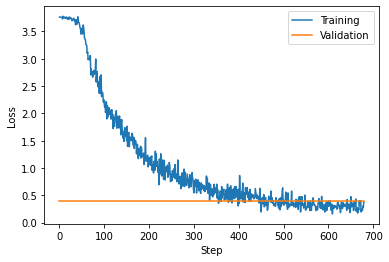

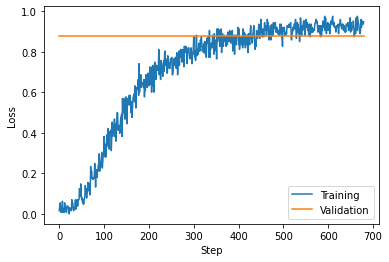

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(680),model.loss_list)
plt.plot(range(680), np.repeat(0.394, 680))
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

plt.plot(range(680),model.acc_list)
plt.plot(range(680), np.repeat(0.878, 680))
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

In [16]:
predictions = []
for i in range(x_test.shape[0]):
    predictions.append(np.argmax(model.predict(x_test[i][None, :, :, :])))

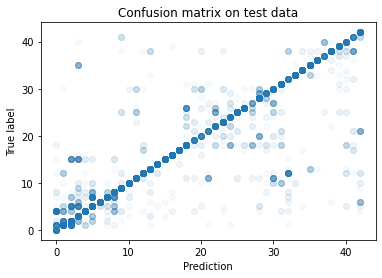

In [17]:
plt.scatter(predictions, y_test, alpha=0.03)
plt.title('Confusion matrix on test data')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()

In [28]:
dictionary = {}
for i, label in enumerate(labels):
    dictionary[i] = label
    print(i, ' : ', label)

0  :  Speed limit (20km/h)
1  :  Speed limit (30km/h)
2  :  Speed limit (50km/h)
3  :  Speed limit (60km/h)
4  :  Speed limit (70km/h)
5  :  Speed limit (80km/h)
6  :  End of speed limit (80km/h)
7  :  Speed limit (100km/h)
8  :  Speed limit (120km/h)
9  :  No passing
10  :  No passing for vehicles over 3.5 metric tons
11  :  Right-of-way at the next intersection
12  :  Priority road
13  :  Yield
14  :  Stop
15  :  No vehicles
16  :  Vehicles over 3.5 metric tons prohibited
17  :  No entry
18  :  General caution
19  :  Dangerous curve to the left
20  :  Dangerous curve to the right
21  :  Double curve
22  :  Bumpy road
23  :  Slippery road
24  :  Road narrows on the right
25  :  Road work
26  :  Traffic signals
27  :  Pedestrians
28  :  Children crossing
29  :  Bicycles crossing
30  :  Beware of ice/snow
31  :  Wild animals crossing
32  :  End of all speed and passing limits
33  :  Turn right ahead
34  :  Turn left ahead
35  :  Ahead only
36  :  Go straight or right
37  :  Go straight 

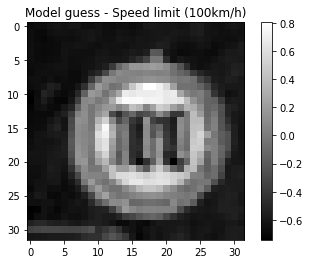

In [30]:
image_n = 12
pred_label = np.argmax(model.predict(x_test[image_n][None, :, : , :]))
plt.imshow(x_test[image_n][0], cmap='gray')

plt.title(f'Model guess - {dictionary[pred_label]}')
plt.colorbar()
plt.show()